In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *
import copy

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
####################################### Set Axes
def set_axes(ax_list, xlim, ylim):
    for ax in ax_list:
        
        ax.set_ylim(ylim)
        ax.set_xlim(xlim) 
        ax.tick_params(which='major', length=8, width=1.5, direction='in')
        ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')  

        y_ax = ax.twinx()
        y_ax.set_ylim(ylim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=8, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')        

        x_ax = ax.twiny()
        x_ax.set_xlim(xlim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=8, width=1.0, direction='in')
        x_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')     


        
####################################### Plotting Function

In [3]:
calib_maglim = [3974, 6699, 9962, 11139, 12460, 13163, 19871, 
                21102, 22277, 26761, 28378, 29128, 38148, 41020, 
                41093, 44982, 45084, 46127, 49448, 50073, 53641, 67908, 72228]

W1_maglim = [38803, 39181, 39431, 39619, 40005, 40107, 40147, 40588, 
             40604, 41567, 41829, 42768, 5807403, 5057729, 4002181, 4321374, 37814, 
             14548, 14590]


In [18]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)


pgc_tab = table['pgc']
u_tab   = table['u_sss']
g_tab   = table['g_sss']
r_tab   = table['r_sss']
i_tab   = table['i_sss']
z_tab   = table['z_sss']
w1_tab  = table['w1_sss']
w2_tab  = table['w2_sss']
m21_tab = table['m21']
inc_tab = table['inc']
Sqlt = table['Sqlt']
Wqlt = table['Wqlt']
logWimx = table['logWimx']
logWimx_e = table['logWimx_e']

indx, = np.where(Sqlt>=3)
uuu  = u_tab[indx]
ggg  = g_tab[indx]
rrr  = r_tab[indx]
iii  = i_tab[indx]
zzz  = z_tab[indx]
w11  = w1_tab[indx]
w22  = w2_tab[indx]
logWimx = logWimx[indx]
logWimx_e = logWimx_e[indx]
Sqlt = Sqlt[indx]
Wqlt = Wqlt[indx]

u_i   = uuu-iii
g_i   = ggg-iii
r_i   = rrr-iii
i_z   = iii-zzz
g_z   = ggg-zzz

indx, = np.where(Wqlt>=3)
uuu  = uuu[indx]
ggg  = ggg[indx]
rrr  = rrr[indx]
iii  = iii[indx]
zzz  = zzz[indx]
w11  = w11[indx]
w22  = w22[indx]
logWimx_ir = logWimx[indx]
logWimx_e_ir = logWimx_e[indx]
Sqlt = Sqlt[indx]
Wqlt = Wqlt[indx]

i_w1  = iii-w11
i_w2  = iii-w22
g_w1  = ggg-w11

print len(r_i)
print len(g_i)
print len(logWimx)
print len(logWimx_e)

print len(i_w1)
print len(i_w2)
print len(logWimx_ir)
print len(logWimx_e_ir)
print len(g_w1)


7438
7438
7438
7438
2176
2176
2176
2176
2176


In [5]:
s_u, z_u, samples = linMC(logWimx-2.5, u_i, logWimx_e, u_i*0+np.sqrt(0.05**2+0.1**2))
s_g, z_g, samples = linMC(logWimx-2.5, g_i, logWimx_e, g_i*0+np.sqrt(0.05**2+0.05**2))
s_r, z_r, samples = linMC(logWimx-2.5, r_i, logWimx_e, r_i*0+np.sqrt(0.05**2+0.05**2))
s_z, z_z, samples = linMC(logWimx-2.5, i_z, logWimx_e, i_z*0+np.sqrt(0.05**2+0.05**2))
s_w1, z_w1, samples = linMC(logWimx_ir-2.5, i_w1, logWimx_e_ir, i_w1*0+np.sqrt(0.05**2+0.05**2))
s_w2, z_w2, samples = linMC(logWimx_ir-2.5, i_w2, logWimx_e_ir, i_w2*0+np.sqrt(0.05**2+0.05**2))

s_gz, z_gz, samples = linMC(logWimx-2.5, g_z, logWimx_e, g_z*0+np.sqrt(0.05**2+0.05**2))

In [6]:
def rmsMaker(logWimx, mag, slope, zp):
    
    mag_fit = slope*(logWimx-2.5)+zp
    rms = np.sqrt(np.mean((mag-mag_fit)**2))
    
    data = {'A':logWimx, 'B':mag}
    d = pd.DataFrame.from_dict(data)
    corr = d.corr()
    
    return rms, corr['A']['B']

u 7438 2.68 1.58 0.87 0.33
g 7438 0.84 0.64 0.18 0.66
r 7438 0.27 0.23 0.07 0.61
z 7438 0.25 0.12 0.07 0.47
W1 2176 1.18 -0.47 0.23 0.66
W2 2176 1.32 -1.04 0.28 0.60


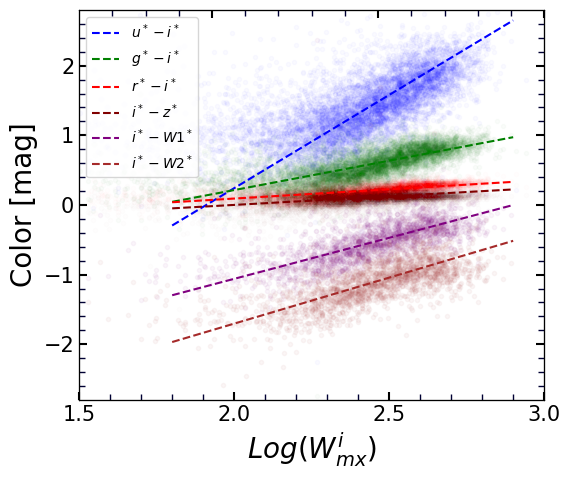

In [7]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

ax.plot(logWimx, u_i, 'b.', alpha=0.02)
ax.plot(logWimx, g_i, 'g.', alpha=0.02)
ax.plot(logWimx, r_i, 'r.', alpha=0.008)
ax.plot(logWimx, i_z, '.', alpha=0.008, color='maroon')
ax.plot(logWimx_ir, i_w1, '.', alpha=0.04, color='purple')
ax.plot(logWimx_ir, i_w2, '.', alpha=0.04, color='brown')

x0 = np.linspace(1.8,2.9,50)
l_u, = ax.plot(x0, s_u[0]*(x0-2.5)+z_u[0], 'b--', label='$u^*-i^*$')
l_g, = ax.plot(x0, s_g[0]*(x0-2.5)+z_g[0], 'g--', label='$g^*-i^*$')
l_r, = ax.plot(x0, s_r[0]*(x0-2.5)+z_r[0], 'r--', label='$r^*-i^*$')
l_z, = ax.plot(x0, s_z[0]*(x0-2.5)+z_z[0], '--', color='maroon', label='$i^*-z^*$')
l_w1, = ax.plot(x0, s_w1[0]*(x0-2.5)+z_w1[0], '--', color='purple', label='$i^*-W1^*$')
l_w2, = ax.plot(x0, s_w2[0]*(x0-2.5)+z_w2[0], '--', color='brown', label='$i^*-W2^*$')

xLim = (1.6,3)
yLim = (-2.8,2.8)

ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')
ax.legend(loc=2)

ax.set_xticks(np.arange(1.5, 3.5, step=0.5))

if True:
    y_ax = ax.twinx()
    y_ax.set_ylim(yLim)
    y_ax.set_yticklabels([])
    y_ax.minorticks_on()
    y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

if True:
    x_ax = ax.twiny()
    x_ax.set_xlim(xLim)
    x_ax.set_xticklabels([])
    x_ax.minorticks_on()
    x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     
    x_ax.set_xticks(np.arange(2.0, 3.5, step=0.5))


for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(15) 
        
        
ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=20) 
ax.set_ylabel('Color [mag]', fontsize=20) 

rms_u, corr_u = rmsMaker(logWimx, u_i, s_u[0], z_u[0])
rms_g, corr_g = rmsMaker(logWimx, g_i, s_g[0], z_g[0])

indx, = np.where((r_i<2) & (r_i>-2))
rms_r, corr_r = rmsMaker(logWimx[indx], r_i[indx], s_r[0], z_r[0])


indx, = np.where((i_z<0.2) & (i_z>-0.2))
rms_z, corr_z = rmsMaker(logWimx[indx], i_z[indx], s_z[0], z_z[0])


rms_w1, corr_w1 = rmsMaker(logWimx_ir, i_w1, s_w1[0], z_w1[0])
rms_w2, corr_w2 = rmsMaker(logWimx_ir, i_w2, s_w2[0], z_w2[0])


print 'u', len(logWimx), '%.2f'%s_u[0], '%.2f'%z_u[0], '%.2f'%rms_u, '%.2f'%corr_u
print 'g', len(logWimx), '%.2f'%s_g[0], '%.2f'%z_g[0], '%.2f'%rms_g, '%.2f'%corr_g
print 'r', len(logWimx), '%.2f'%s_r[0], '%.2f'%z_r[0], '%.2f'%rms_r, '%.2f'%corr_r
print 'z', len(logWimx), '%.2f'%s_z[0], '%.2f'%z_z[0], '%.2f'%rms_z, '%.2f'%corr_z
print 'W1', len(logWimx_ir), '%.2f'%s_w1[0], '%.2f'%z_w1[0], '%.2f'%rms_w1, '%.2f'%corr_w1
print 'W2', len(logWimx_ir), '%.2f'%s_w2[0], '%.2f'%z_w2[0], '%.2f'%rms_w2, '%.2f'%corr_w2

g 7438 1.56 0.79 0.46 0.41


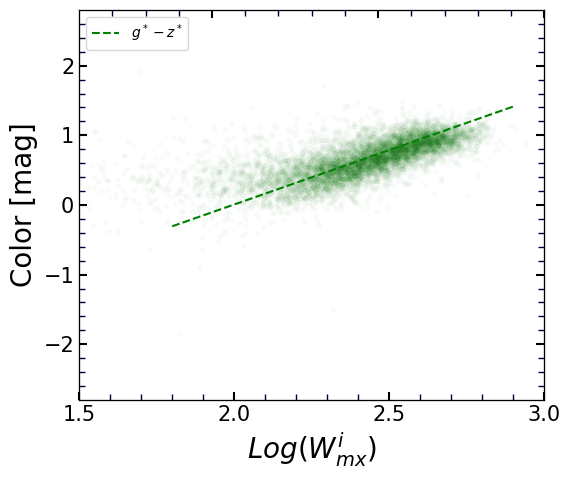

In [8]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

ax.plot(logWimx, g_z, 'g.', alpha=0.02)


x0 = np.linspace(1.8,2.9,50)

l_gz, = ax.plot(x0, s_gz[0]*(x0-2.5)+z_gz[0], 'g--', label='$g^*-z^*$')


xLim = (1.6,3)
yLim = (-2.8,2.8)

ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')
ax.legend(loc=2)

ax.set_xticks(np.arange(1.5, 3.5, step=0.5))

if True:
    y_ax = ax.twinx()
    y_ax.set_ylim(yLim)
    y_ax.set_yticklabels([])
    y_ax.minorticks_on()
    y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

if True:
    x_ax = ax.twiny()
    x_ax.set_xlim(xLim)
    x_ax.set_xticklabels([])
    x_ax.minorticks_on()
    x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     
    x_ax.set_xticks(np.arange(2.0, 3.5, step=0.5))


for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(15) 
        
        
ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=20) 
ax.set_ylabel('Color [mag]', fontsize=20) 

rms_gz, corr_gz = rmsMaker(logWimx, g_z, s_gz[0], z_gz[0])




print 'g', len(logWimx), '%.2f'%s_gz[0], '%.2f'%z_gz[0], '%.2f'%rms_gz, '%.2f'%corr_gz


In [9]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
catal   = np.genfromtxt('ESN_HI_catal_all.csv' , delimiter=',', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_catal   = catal['pgc']
R50u_catal  = catal['R50_u']
R50g_catal  = catal['R50_g']
R50r_catal  = catal['R50_r']
R50i_catal  = catal['R50_i']
R50z_catal  = catal['R50_z']
R50w1_catal = catal['R50_w1']
R50w2_catal = catal['R50_w2']
Sba_catal   = catal['Sba']
Wba_catal   = catal['Wba']

pgc = table['pgc']
u_tab   = table['u_sss']
g_tab   = table['g_sss']
r_tab   = table['r_sss']
i_tab   = table['i_sss']
z_tab   = table['z_sss']
w1_tab  = table['w1_sss']
w2_tab  = table['w2_sss']
m21_tab = table['m21']
inc_tab = table['inc']
logWimx = table['logWimx']
logWimx_e = table['logWimx_e']
Sqlt = table['Sqlt']
Wqlt = table['Wqlt']

N = len(pgc)
inc  = np.zeros(N)
m21  = np.zeros(N)
Sba  = np.zeros(N)
Wba  = np.zeros(N)

uuu  = np.zeros(N)
ggg  = np.zeros(N)
rrr  = np.zeros(N)
iii  = np.zeros(N)
zzz  = np.zeros(N)
w11  = np.zeros(N)
w22  = np.zeros(N)

R50u  = np.zeros(N)
R50g  = np.zeros(N)
R50r  = np.zeros(N)
R50i  = np.zeros(N)
R50z  = np.zeros(N)
R50w1 = np.zeros(N)
R50w2 = np.zeros(N)

for i, idd in enumerate(pgc):
    if idd in pgc_catal:
        indx,   = np.where(pgc_catal==idd)
        R50u[i]  = R50u_catal[indx][0]
        R50g[i]  = R50g_catal[indx][0]
        R50r[i]  = R50r_catal[indx][0]
        R50i[i]  = R50i_catal[indx][0]
        R50z[i]  = R50z_catal[indx][0]
        R50w1[i] = R50w1_catal[indx][0]
        R50w2[i] = R50w2_catal[indx][0]
        Sba[i]   = Sba_catal[indx][0]
        Wba[i]   = Wba_catal[indx][0]

    inc[i] = inc_tab[i]
    uuu[i] = u_tab[i]
    ggg[i] = g_tab[i]
    rrr[i] = r_tab[i]
    iii[i] = i_tab[i]
    zzz[i] = z_tab[i]
    w11[i] = w1_tab[i]
    w22[i] = w2_tab[i]
    m21[i] = m21_tab[i]
    
mu50_u  = uuu+2.5*np.log10(2.*np.pi*(R50u*60)**2)-2.5*np.log10(Sba)
mu50_g  = ggg+2.5*np.log10(2.*np.pi*(R50g*60)**2)-2.5*np.log10(Sba)
mu50_r  = rrr+2.5*np.log10(2.*np.pi*(R50r*60)**2)-2.5*np.log10(Sba)
mu50_i  = iii+2.5*np.log10(2.*np.pi*(R50i*60)**2)-2.5*np.log10(Sba)
mu50_z  = zzz+2.5*np.log10(2.*np.pi*(R50z*60)**2)-2.5*np.log10(Sba)
m21_u   = m21 - uuu
m21_g   = m21 - ggg
m21_r   = m21 - rrr
m21_i   = m21 - iii
m21_z   = m21 - zzz
indx, = np.where(Sqlt>=3)
logWimx_op = logWimx[indx]
mu50_u  = mu50_u[indx]
mu50_g  = mu50_g[indx]
mu50_r  = mu50_r[indx]
mu50_i  = mu50_i[indx]
mu50_z  = mu50_z[indx]
m21_u   = m21_u[indx]
m21_g   = m21_g[indx]
m21_r   = m21_r[indx]
m21_i   = m21_i[indx]
m21_z   = m21_z[indx]

mu50_w1  = w11+2.5*np.log10(2.*np.pi*(R50w1*60)**2)-2.5*np.log10(Wba)
mu50_w2  = w22+2.5*np.log10(2.*np.pi*(R50w2*60)**2)-2.5*np.log10(Wba)
m21_w1   = m21 - w11
m21_w2   = m21 - w22
indx, = np.where(Wqlt>=3)
logWimx_ir = logWimx[indx]
mu50_w1  = mu50_w1[indx]
mu50_w2  = mu50_w2[indx]
m21_w1   = m21_w1[indx]
m21_w2   = m21_w2[indx]

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invali

In [10]:
def Plot_m21(logWimx, m21_color, ax=None, yLim = (-5,5), color=None, alpha=0.1, band='u'):
    
    dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}
    if color is None:
        color=dye[band]
        
        
    indx, = np.where((m21_color<7) & (m21_color>-7))
    
    fit, cov = curve_fit(linfit, logWimx[indx]-2.5, m21_color[indx])
    sl,zp = fit
    
    rms, correlation = rmsMaker(logWimx[indx], m21_color[indx], sl, zp)
    
    print band, '%.2f'%sl, '%.2f'%zp, '%.2f'%rms, '%.2f'%correlation
    
    if ax is None:
        return sl,zp, rms, correlation
        
    
    ax.plot(logWimx, m21_color, '.', color=color, alpha=alpha)
    x0 = np.linspace(1.7,2.8,50)
    ax.plot(x0, sl*(x0-2.5)+zp, 'k--')

    xLim = (1.6,2.9)

    ax.set_xlim(xLim)        
    ax.set_ylim(yLim)
    ax.tick_params(which='major', length=6, width=1.5, direction='in')
    ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

    ax.set_xticks(np.arange(2.0, 3.0, step=0.5))
    ax.set_yticks(np.arange(-4,5, step=4))

    if True:
        y_ax = ax.twinx()
        y_ax.set_ylim(yLim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in') 
        y_ax.set_yticks(np.arange(-4,5, step=4))

    if True:
        x_ax = ax.twiny()
        x_ax.set_xlim(xLim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     
        x_ax.set_xticks(np.arange(2.0, 3.0, step=0.5))


    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
        
    
    
    return sl,zp, rms, correlation

u 1.30 0.84 0.74 0.36
g 1.86 1.73 0.79 0.46
r 2.31 2.14 0.86 0.51
i 2.56 2.36 0.89 0.54
z 2.72 2.47 0.91 0.56
w1 3.27 2.22 1.00 0.53
w2 3.32 1.65 1.02 0.53


Text(0,0.5,'$m_{21}-W2^*$')

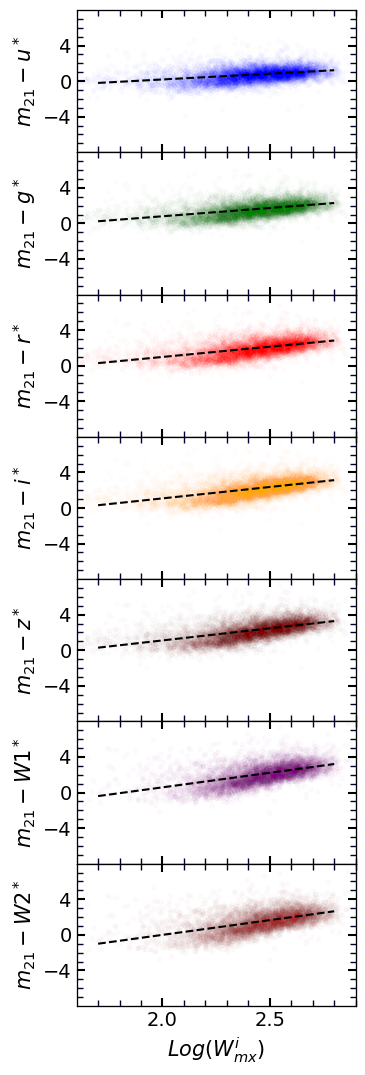

In [11]:
fig = py.figure(figsize=(3., 12), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.05, right=0.98)
gs = gridspec.GridSpec(7,1) ; p = 0

plt.subplots_adjust(hspace=.0, wspace=0)


ax = plt.subplot(gs[p]) ; p+=1
Plot_m21(logWimx_op, m21_u, band='u', ax=ax, yLim = (-8.,8.), alpha=0.01)
ax.set_ylabel(r'$m_{21}-u^*$', fontsize=15)

ax = plt.subplot(gs[p]) ; p+=1
Plot_m21(logWimx_op, m21_g, band='g', ax=ax, yLim = (-8.,8.), alpha=0.01)
ax.set_ylabel(r'$m_{21}-g^*$', fontsize=15)

ax = plt.subplot(gs[p]) ; p+=1
Plot_m21(logWimx_op, m21_r, band='r', ax=ax, yLim = (-8.,8.), alpha=0.01)
ax.set_ylabel(r'$m_{21}-r^*$', fontsize=15)

ax = plt.subplot(gs[p]) ; p+=1
Plot_m21(logWimx_op, m21_i, band='i', ax=ax, yLim = (-8.,8.), alpha=0.01)
ax.set_ylabel(r'$m_{21}-i^*$', fontsize=15)

ax = plt.subplot(gs[p]) ; p+=1
Plot_m21(logWimx_op, m21_z, band='z', ax=ax, yLim = (-8.,8.), alpha=0.01)
ax.set_ylabel(r'$m_{21}-z^*$', fontsize=15)

ax = plt.subplot(gs[p]) ; p+=1
Plot_m21(logWimx_ir, m21_w1, band='w1', ax=ax, yLim = (-8.,8.), alpha=0.015)
ax.set_ylabel(r'$m_{21}-W1^*$', fontsize=15)

ax = plt.subplot(gs[p]) ; p+=1
Plot_m21(logWimx_ir, m21_w2, band='w2', ax=ax, yLim = (-8.,8.), alpha=0.015)
ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=15)
ax.set_ylabel(r'$m_{21}-W2^*$', fontsize=15)

In [12]:
def Plot_mu50(logWimx, m21_color, ax=None, yLim = (-5,5), color=None, alpha=0.1, band='u'):
    
    dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}
    if color is None:
        color=dye[band]
        
        
    indx, = np.where(m21_color>0)
    
    fit, cov = curve_fit(linfit, logWimx[indx]-2.5, m21_color[indx])
    sl,zp = fit
    
    rms, correlation = rmsMaker(logWimx[indx], m21_color[indx], sl, zp)
    
    print band, '%.2f'%sl, '%.2f'%zp, '%.2f'%rms, '%.2f'%np.abs(correlation)
    
    if ax is None:
        return sl,zp, rms, correlation
        
    
    ax.plot(logWimx, m21_color, '.', color=color, alpha=alpha)
    x0 = np.linspace(1.7,2.8,50)
    ax.plot(x0, sl*(x0-2.5)+zp, 'k--')

    xLim = (1.6,2.9)

    ax.set_xlim(xLim)        
    ax.set_ylim(yLim)
    ax.tick_params(which='major', length=6, width=1.5, direction='in')
    ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

    ax.set_xticks(np.arange(2.0, 3.0, step=0.5))
    ax.set_yticks(np.arange(20,30, step=4))

    if True:
        y_ax = ax.twinx()
        y_ax.set_ylim(yLim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in') 
        y_ax.set_yticks(np.arange(20,30, step=4))

    if True:
        x_ax = ax.twiny()
        x_ax.set_xlim(xLim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     
        x_ax.set_xticks(np.arange(2.0, 3.0, step=0.5))


    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
        
    
    
    return sl,zp, rms, correlation

u -0.95 24.30 1.37 0.15
g -1.92 23.28 1.08 0.37
r -2.70 22.74 1.13 0.47
i -3.12 22.48 1.14 0.52
z -3.45 22.26 1.16 0.55
w1 -4.05 22.63 1.22 0.54
w2 -4.06 23.21 1.41 0.49


Text(0.5,0,'$Log( W_{mx}^i)$')

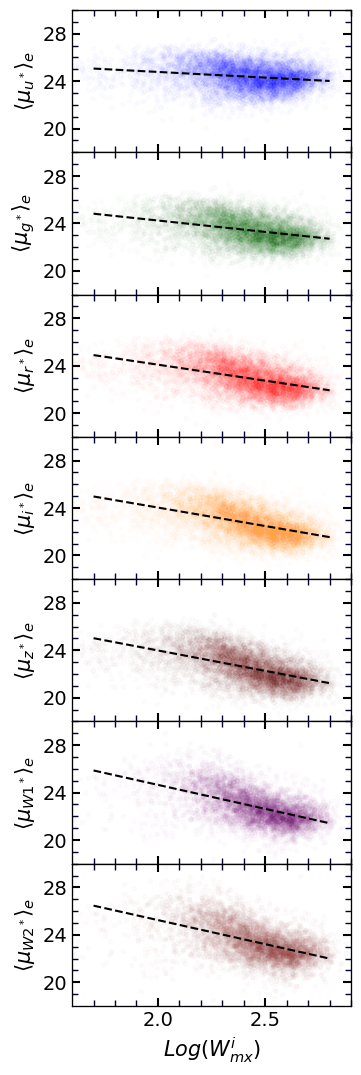

In [13]:
fig = py.figure(figsize=(3., 12), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.05, right=0.98)
gs = gridspec.GridSpec(7,1) ; p = 0

plt.subplots_adjust(hspace=.0, wspace=0)


ax = plt.subplot(gs[p]) ; p+=1
Plot_mu50(logWimx_op, mu50_u, band='u', ax=ax, yLim = (18,30), alpha=0.01)
ax.set_ylabel(r'$\langle\mu_{u^*}\rangle_e$', fontsize=15)

ax = plt.subplot(gs[p]) ; p+=1
Plot_mu50(logWimx_op, mu50_g, band='g', ax=ax, yLim = (18,30), alpha=0.01)
ax.set_ylabel(r'$\langle\mu_{g^*}\rangle_e$', fontsize=15)

ax = plt.subplot(gs[p]) ; p+=1
Plot_mu50(logWimx_op, mu50_r, band='r', ax=ax, yLim = (18,30), alpha=0.01)
ax.set_ylabel(r'$\langle\mu_{r^*}\rangle_e$', fontsize=15)

ax = plt.subplot(gs[p]) ; p+=1
Plot_mu50(logWimx_op, mu50_i, band='i', ax=ax, yLim = (18,30), alpha=0.01)
ax.set_ylabel(r'$\langle\mu_{i^*}\rangle_e$', fontsize=15)

ax = plt.subplot(gs[p]) ; p+=1
Plot_mu50(logWimx_op, mu50_z, band='z', ax=ax, yLim = (18,30), alpha=0.01)
ax.set_ylabel(r'$\langle\mu_{z^*}\rangle_e$', fontsize=15)


ax = plt.subplot(gs[p]) ; p+=1
Plot_mu50(logWimx_ir, mu50_w1, band='w1', ax=ax, yLim = (18,30), alpha=0.015)
ax.set_ylabel(r'$\langle\mu_{W1^*}\rangle_e$', fontsize=15)


ax = plt.subplot(gs[p]) ; p+=1
Plot_mu50(logWimx_ir, mu50_w2, band='w2', ax=ax, yLim = (18,30), alpha=0.015)
ax.set_ylabel(r'$\langle\mu_{W2^*}\rangle_e$', fontsize=15)

ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=15)


In [14]:
def Plot_P1w(logWimx, m21_color, ax=None, yLim = (-5,5), color=None, alpha=0.1, band='u'):
    
    dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}
    if color is None:
        color=dye[band]
        
        
    indx, = np.where((m21_color>-6) & (m21_color<6))
    
    fit, cov = curve_fit(linfit, logWimx[indx]-2.5, m21_color[indx])
    sl,zp = fit
    
    rms, correlation = rmsMaker(logWimx[indx], m21_color[indx], sl, zp)
    
    print band, '%.2f'%sl, '%.2f'%zp, '%.2f'%rms, '%.2f'%np.abs(correlation)
    
    if ax is None:
        return sl,zp, rms, correlation
        
    
    ax.plot(logWimx, m21_color, '.', color=color, alpha=alpha)
    x0 = np.linspace(1.7,2.8,50)
    ax.plot(x0, sl*(x0-2.5)+zp, 'k--')

    xLim = (1.6,2.9)

    ax.set_xlim(xLim)        
    ax.set_ylim(yLim)
    ax.tick_params(which='major', length=6, width=1.5, direction='in')
    ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

    ax.set_xticks(np.arange(2.0, 3.0, step=0.5))
    ax.set_yticks(np.arange(-4,8, step=4))

    if True:
        y_ax = ax.twinx()
        y_ax.set_ylim(yLim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in') 
        y_ax.set_yticks(np.arange(-4,8, step=4))

    if True:
        x_ax = ax.twiny()
        x_ax.set_xlim(xLim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     
        x_ax.set_xticks(np.arange(2.0, 3.0, step=0.5))


    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
        
    
    
    return sl,zp, rms, correlation

[22.83126938  2.0750347 ] [1.44603259 1.3387027 ]
-0.7071067811865488 0.7071067811865478
w1 3.72 0.18 1.01 0.58
--------------
[23.42038508  1.50795114] [1.60951942 1.43593642]
0.7071067811865472 -0.7071067811865476
w2 3.44 0.16 0.95 0.57


Text(0.5,0,'$Log( W_{mx}^i)$')

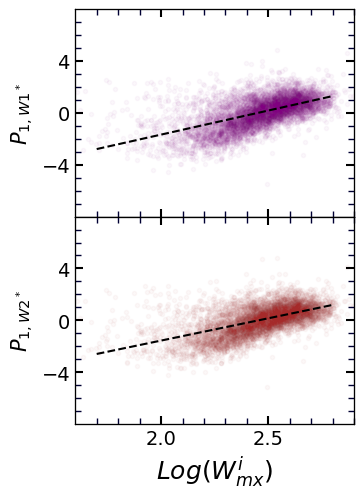

In [15]:
fig = py.figure(figsize=(3., 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.05, right=0.98)
gs = gridspec.GridSpec(2,1) ; p = 0
plt.subplots_adjust(hspace=.0, wspace=0)



indx, = np.where(mu50_w1>0)
data = {'a':mu50_w1[indx], 'b':m21_w1[indx]}
order_of_keys = ['a', 'b']
list_of_tuples = [(key, data[key]) for key in order_of_keys]
data = OrderedDict(list_of_tuples)
z_scaler = StandardScaler()
n_comp = len(data)
d = pd.DataFrame.from_dict(data)
z_data = z_scaler.fit_transform(d)
pca_transform = PCA().fit(z_data)
pca_data = pca_transform.transform(z_data)
pc0 = pca_data[:,0]
u = z_scaler.mean_
s = z_scaler.scale_
v = z_scaler.var_
## z = (x-u)/s
##u: mean  s:scale  var=s**2
pca_inv_data = pca_transform.inverse_transform(np.eye(n_comp)) # coefficients to make PCs from features
p0 = pca_inv_data[0,0]
p1 = pca_inv_data[0,1]
print u,s
print p0, p1

ax = plt.subplot(gs[p]) ; p+=1
Plot_P1w(logWimx_ir[indx], pc0, band='w1', ax=ax, yLim = (-8,8), alpha=0.03)
ax.set_ylabel(r'$P_{1,W1^*}$', fontsize=15)


print '--------------'


indx, = np.where(mu50_w2>0)
data = {'a':mu50_w2[indx], 'b':m21_w2[indx]}
order_of_keys = ['a', 'b']
list_of_tuples = [(key, data[key]) for key in order_of_keys]
data = OrderedDict(list_of_tuples)
z_scaler = StandardScaler()
n_comp = len(data)
d = pd.DataFrame.from_dict(data)
z_data = z_scaler.fit_transform(d)
pca_transform = PCA().fit(z_data)
pca_data = pca_transform.transform(z_data)
pc0 = pca_data[:,0]
u = z_scaler.mean_
s = z_scaler.scale_
v = z_scaler.var_
## z = (x-u)/s
##u: mean  s:scale  var=s**2
pca_inv_data = pca_transform.inverse_transform(np.eye(n_comp)) # coefficients to make PCs from features
p0 = pca_inv_data[0,0]
p1 = pca_inv_data[0,1]
print u,s
print p0, p1

ax = plt.subplot(gs[p]) ; p+=1
Plot_P1w(logWimx_ir[indx], -pc0, band='w2', ax=ax, yLim = (-8,8), alpha=0.03)
ax.set_ylabel(r'$P_{1,W2^*}$', fontsize=15)

ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18)

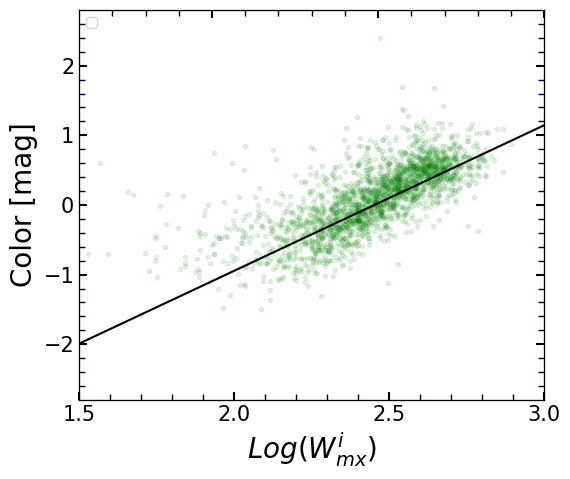

In [21]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

ax.plot(logWimx_ir, g_w1, 'g.', alpha=0.1)


x0 = np.linspace(1.8,2.9,50)

# l_gz, = ax.plot(x0, s_gz[0]*(x0-2.5)+z_gz[0], 'g--', label='$g^*-z^*$')


xLim = (1.6,3)
yLim = (-2.8,2.8)

ax.set_xlim(xLim)        
ax.set_ylim(yLim)
ax.tick_params(which='major', length=6, width=1.5, direction='in')
ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')
ax.legend(loc=2)

ax.set_xticks(np.arange(1.5, 3.5, step=0.5))

if True:
    y_ax = ax.twinx()
    y_ax.set_ylim(yLim)
    y_ax.set_yticklabels([])
    y_ax.minorticks_on()
    y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

if True:
    x_ax = ax.twiny()
    x_ax.set_xlim(xLim)
    x_ax.set_xticklabels([])
    x_ax.minorticks_on()
    x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
    x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     
    x_ax.set_xticks(np.arange(2.0, 3.5, step=0.5))


for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(15) 
        
        
ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=20) 
ax.set_ylabel('Color [mag]', fontsize=20) 

# rms_gz, corr_gz = rmsMaker(logWimx_ir, g_z, s_gz[0], z_gz[0])




# print 'g', len(logWimx), '%.2f'%s_gz[0], '%.2f'%z_gz[0], '%.2f'%rms_gz, '%.2f'%corr_gz
wimx = np.linspace(1.5,3, 20)
g_w1 = (-7.37*(wimx-2.5)-20.15-0.11)-(-9.46*(wimx-2.5)-20.36)
ax.plot(wimx, g_w1, 'k-')